<h1 style="font-size: 26px; color: white; background-color: #334580; padding: 10px; border-radius: 5px; text-align: center;">
    Fish Classification with Convolutional Neural Network (CNN) 
</h1>

<h1 style="font-size: 22px; color: black; background-color: #b4c4df; padding: 10px; border-radius: 5px; text-align: left;">
    1.Problem Statement
</h1>

<p style="font-size: 16px; color: black; text-align: left;">

The goal of this pipeline is to classify fish images by using pictures into 9 categories. This helps a fish packing company label and pack fish correctly,  meeting regulatory and customer requirements.

Accurate fish classification reduces errors in packaging and ensures compliance with industry standards. Automating this process enhance efficiency, reduce labor cost and streamline operations.

This is a supervised image classification problem. The model will be trained and learn feautures like size, color, shape from labeled images in order to accurately predict fish species. The model's performance will be evaluated using metrics such as accuracy, precision to ensure reliable results.


</p>

<h1 style="font-size: 22px; color: black; background-color: #b4c4df; padding: 10px; border-radius: 5px; text-align: left;">
   2.About Dataset
</h1> 

<p style="font-size: 16px; color: black; text-align: left;">

To build the fish classification model, a dataset containing labeled images of different fish species is essential. For this task, the Large Scale Fish Dataset from Kaggle is a reliable source. It contains 9,000 images across 9 species, with 1,000 images per species, ensuring balanced representation. The dataset can be accessed at this link: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset/data

</p>

<p style="font-size: 16px; color: black; text-align: left;">

There are 9 different folders, each corresponding to a fish category. Each folder contains 1,000 augmented images belonging to that category. Additionally, each category has 1,000 images for their pairwise augmented ground truths (GT). I removed the GT folders from the dataset since they will not be used for classification in this pipeline.

</p>

<h1 style="font-size: 22px; color: black; background-color: #b4c4df; padding: 10px; border-radius: 5px; text-align: left;">
   3.Importing Libraries
</h1> 

In [12]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import itertools
import os
import shutil
import random
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

<h1 style="font-size: 22px; color: black; background-color: #b4c4df; padding: 10px; border-radius: 5px; text-align: left;">
   4.Basic EDA
</h1> 

In [63]:
#Folder path
original_dataset_dir = './Fish_Dataset/Main_Fish_DataSet'

In [67]:
classes = [i for i in os.listdir(original_dataset_dir) if '.' not in i]                    
print('Name of the classes; ')
classes

Name of the classes; 


['Black Sea Sprat',
 'Gilt-Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [67]:
print('The folder names and number of images they contain:\n')
for folder_name in os.listdir(original_dataset_dir):
    folder_path = os.path.join(original_dataset_dir, folder_name)
    
   
    if os.path.isdir(folder_path):
        #List all files in the folder
        images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        
    
        print(f"Folder: {folder_name}, Number of images: {len(images)}")


The folder names and number of images they contain:

Folder: Black Sea Sprat, Number of images: 1000
Folder: Gilt-Head Bream, Number of images: 1000
Folder: Hourse Mackerel, Number of images: 1000
Folder: Red Mullet, Number of images: 1000
Folder: Red Sea Bream, Number of images: 1000
Folder: Sea Bass, Number of images: 1000
Folder: Shrimp, Number of images: 1000
Folder: Striped Red Mullet, Number of images: 1000
Folder: Trout, Number of images: 1000


<p style="font-size: 16px; color: black; text-align: left;">
This result indicates that there is no imbalance issue in the dataset.
</p>

<p style="font-size: 16px; color: black; text-align: left;">
Example pictures from each fish category; 
</p>



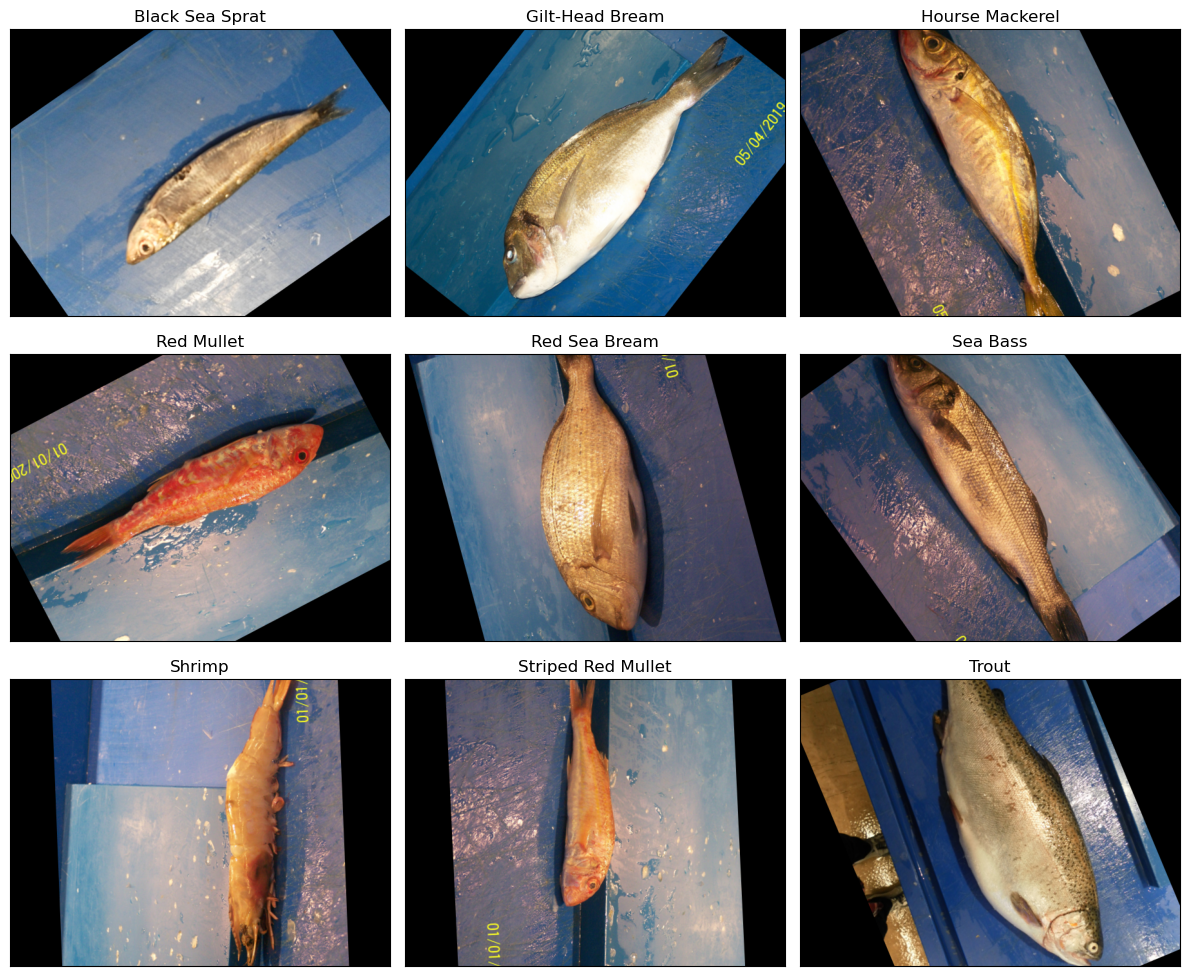

In [95]:
from PIL import Image

#Grades for 3 columns x 3 rows
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10), subplot_kw={'xticks': [], 'yticks': []})

#Loop through the folders and display one image from each folder
for i, folder_name in enumerate(folder_names[:9]):  #There are 9 folders
    folder_path = os.path.join(original_dataset_dir, folder_name)
    #Get image files in each folder (assuming images are in the folder)
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    #Select the first image from each folder
    img_name = images[0]
    img_path = os.path.join(folder_path, img_name)
    
    #Open and display the image
    img = Image.open(img_path)
    
    #Set the current axis and show the image
    ax = axes.flat[i]
    ax.imshow(img)
    ax.set_title(folder_name)  

plt.tight_layout()
plt.show()


<h1 style="font-size: 22px; color: black; background-color: #b4c4df; padding: 10px; border-radius: 5px; text-align: left;">
   5.Splitting Dataset
</h1>

<p style="font-size: 16px; color: black; text-align: left;">
    
The dataset is splited into three categories: train, validation, and test, following a 70-15-15 split ratio. A new folder named 'Dataset' was created to store the train, test, and validation images. Each of these folders contains nine subfolders, each representing a fish category. The images were shuffled and copied into their respective subfolders within the 'Dataset' directory.

</p>

In [112]:
#Define paths
base_dir = "./Fish_Dataset/Main_Fish_DataSet/Dataset" #the path of the new folder
train_dir = os.path.join(base_dir, "Train")
val_dir = os.path.join(base_dir, "Validation")
test_dir = os.path.join(base_dir, "Test")

#directories for splits
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Process each class folder
for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name) 
    if os.path.isdir(class_path):  
        #get all image filenames
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(".png")]

        #shuffle the images
        random.shuffle(images)

        # Ensure there are enough images for splitting
        if len(images) < 10:
            print(f"Warning: Not enough images in class {class_name} to split properly!")
            continue

        #split into train, test, validation
        train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)  
        val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)  

        #create subfolders for each class
        for split_dir, split_images in zip([train_dir, val_dir, test_dir], [train_images, val_images, test_images]):
            class_split_dir = os.path.join(split_dir, class_name)
            os.makedirs(class_split_dir, exist_ok=True)

            #copy images to respective folders
            for img_path in split_images:
                shutil.copy(img_path, class_split_dir)

print("Dataset successfully split into Train, Validation, and Test!")

Dataset successfully split into Train, Validation, and Test!
